In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch import nn
import lightning as L
import numpy as np

In [3]:
INPUT_SIZE =50
BATCH_SIZE=100
LEARNING_RATE=0.0001
WINDOW_SIZE = 720

DEVICE = torch.device("mps") if torch.backends.mps.is_available() else  torch.device("cpu")
NUM_WORKERS = os.cpu_count()
print(f'Device:{DEVICE}, Number of workers:{NUM_WORKERS}')

Device:mps, Number of workers:8


In [4]:
DATA_DIR = '/Volumes/Data/Row_Data'
LOAD_FILE = 'kpx_powerDemand_2013_2023_v4.csv'
URL = f'{DATA_DIR}/{LOAD_FILE}'

In [70]:
df_data = pd.read_csv(URL, parse_dates=['date_time'], index_col='date_time')
df_data

,demand,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,hr_20,hr_21,hr_22,hr_23,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,60178,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2013-01-01 01:00:00,57862,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2013-01-01 02:00:00,56165,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2013-01-01 03:00:00,55135,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2013-01-01 04:00:00,54450,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,62902,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2023-12-31 20:00:00,62061,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
2023-12-31 21:00:00,61403,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False


In [71]:
transformer_demand = MinMaxScaler()
transformer_demand.fit( df_data[['demand']] )

MinMaxScaler()

In [5]:
class PowerDemandDataset(Dataset):

    def __init__(self, features, targets=[], window_size=WINDOW_SIZE):
        self.features = features
        self.targets = targets
        self.window_size= window_size
        self.x, self.y = [], []
        # 각 시간간격별 예측시  1시간뒤: x = 0 , 2시간뒤: x = 1, 3시간뒤: x = 2 ...
        #
        # for i in range(len(features) - self.window_size - X):
        #     v = features.iloc[ i: (i + window_size) ].values
        #     self.x.append(v)
        #     self.y.append( target.iloc[ i + window_size + x] )

        
        for i in range(len(features) - self.window_size ):
            v = features.iloc[ i: (i + window_size) ].values
            self.x.append(v)
            self.y.append( features.iloc[ i + window_size ]['demand'] )
            #self.y.append( target[ i + window_size ] )

        # Many to Many output_size = 6
       # for i in range(len(features) - self.window_size - 6 + 1):
       #     self.x.append( features.iloc[ i: (i + window_size) ].values )
       #     a = target[  i + window_size :  i + window_size + 6].values.reshape(-1, 1)
       #     self.y.append( a)

    
    def __getitem__(self, index):
        x = self.x[index].astype(np.float32)
        y = self.y[index].astype(np.float32)
        return x, y

    def __len__(self):
        return len(self.x) 


In [46]:
class PowerDemandDataModule(L.LightningDataModule):
    def __init__(self, data_dir:str, file_name:str):
        super().__init__()
        self.data_dir = data_dir
        self.file_name = file_name
        self.transformer_demand = MinMaxScaler()
        #URL = f'{self.data_dir}/{self.file_name}'
        #self.df_data = pd.read_csv(URL, parse_dates=['date_time'], index_col='date_time')
       # self.transformer_demand.fit( self.df_data[['demand']] )

    def prepare_data(self):
        URL = f'{self.data_dir}/{self.file_name}'
        self.df_data = pd.read_csv(URL, parse_dates=['date_time'], index_col='date_time')
        self.transformer_demand.fit( self.df_data[['demand']] )
        

    def setup(self, stage: str):
        match stage:
            case 'fit':
                self.train_data = self.df_data.loc['2013-01-01':'2020-12-31']
                self.val_data = self.df_data.loc['2020-01-01':'2022-12-31']
            case 'test':
                self.test_data = self.df_data.loc['2023-01-01':'2023-12-31']
            case 'predict':
                self.predict_data = self.df_data.loc['2023-01-01':'2023-12-31']
            case _:
                self.train_data = self.df_data.loc['2013-01-01':'2020-12-31']
                self.val_data = self.df_data.loc['2020-01-01':'2022-12-31']
                self.test_data = self.df_data.loc['2023-01-01':'2023-12-31']
                
    def get_dataset(self, stage:str):
        match stage:
            case 'train':
                self.train_data.demand = self.transformer_demand.transform(self.train_data[['demand']])
                return PowerDemandDataset(features=self.train_data , targets=self.train_data.demand) 
            case 'val':
                self.val_data.demand = self.transformer_demand.transform(self.val_data[['demand']])
                return PowerDemandDataset(features=self.val_data , targets=self.val_data.demand) 
            case 'test':
                self.test_data.demand = self.transformer_demand.transform(self.test_data[['demand']])
                return PowerDemandDataset(features=self.test_data , targets=self.test_data.demand) 
            case 'predict':
                self.predict_data.demand = self.transformer_demand.transform(self.predict_data[['demand']])
                return PowerDemandDataset(features=self.predict_data , targets=self.predict_data.demand)
            case _:
                self.train_data.demand = self.transformer_demand.transform(self.train_data[['demand']])
                return PowerDemandDataset(features=self.train_data , targets=self.train_data.demand) 

    
    def train_dataloader(self):
        return DataLoader( self.get_dataset('train'), batch_size=BATCH_SIZE )

    def val_dataloader(self):
        return DataLoader( self.get_dataset('val'), batch_size=BATCH_SIZE )

    def test_dataloader(self):
        return DataLoader( self.get_dataset('test'), batch_size=BATCH_SIZE )

    def predict_dataloader(self):
        return DataLoader( self.get_dataset('predict'), batch_size=BATCH_SIZE )


    def teardown(self, stage: str):
        import gc
        
        match stage:
            case 'fit':
                del self.train_data
                del self.val_data
            case 'test':
                del self.test_data
            case 'predict':
                del self.predict_data
            case _:
                del self.train_data
                del self.val_data
                del self.test_data
                
        gc.collect()



In [16]:
class PowerDemandPrediction(L.LightningModule):
    def __init__(self, input_size=INPUT_SIZE, output_size=1, hidden_dim=10, n_layers=2, lr=LEARNING_RATE, window_size=WINDOW_SIZE):
        super(PowerDemandPrediction, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim * window_size, output_size)
        self.loss = nn.MSELoss()
        self.flatten = nn.Flatten()
        self.learning_rate = lr
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)    
        lstm_out, (hidden, cell) = self.lstm(x, hidden)
        out = self.flatten(lstm_out)
        out = self.fc(out)
        return out

    def init_hidden(self, batch_size):   
        hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(DEVICE)
        cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(DEVICE)
        hidden = (hidden_state, cell_state)
        return hidden

    def configure_optimizers(self):
        return {'optimizer': torch.optim.Adam(params=self.parameters(), lr = self.learning_rate) }

    def training_step(self, train_batch, batch_idx):
        features, targets = train_batch
        output = self(features) 
        output = output.view(-1)
        loss = self.loss(output, targets)
        self.log('train_loss', loss, prog_bar=True)
        return {"loss": loss}
            
    def validation_step(self, val_batch, batch_idx):
        features, targets = val_batch
        output = self(features) 
        output = output.view(-1)
        loss = self.loss(output, targets)
        self.log('val_loss', loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        features, targets = batch
        result = self(features)
        return result.view(-1).tolist()
        

In [17]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
#from lightning.pytorch.callbacks import DeviceStatsMonitor

LOG_PATH = os.getcwd()
logger = TensorBoardLogger(save_dir=LOG_PATH, name='lightning_logs2')

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)
#device_states_monitor = DeviceStatsMonitor()

In [18]:
trainer = L.Trainer( fast_dev_run=True, accelerator='mps', devices=1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [19]:
trainer = L.Trainer( callbacks=[early_stop_callback], logger=logger, precision="16", max_epochs=10, accelerator='mps', devices=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
model = PowerDemandPrediction().to(DEVICE)
model

PowerDemandPrediction(
  (lstm): LSTM(50, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7200, out_features=1, bias=True)
  (loss): MSELoss()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [47]:
dm = PowerDemandDataModule(DATA_DIR, LOAD_FILE)
dm.prepare_data()

In [48]:
dm.setup('test')
#let's loop it over single iteration and print the shape and also data
for i, (features,targets) in enumerate(dm.get_dataset('test')):
    print("Size of the features",features.shape)
    print("Printing features:\n", features)
    print("Size of the targets",targets.shape)
    print("Printing targets:\n", targets)
    break
dm.teardown('test')    

/var/folders/r5/124yntwj1n7_xfgvd8f6pzv40000gn/T/ipykernel_7676/1707019476.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Size of the features (720, 50)
Printing features:
 [[0.48199946 1.         0.         ... 0.         0.         0.        ]
 [0.44007826 1.         0.         ... 0.         0.         0.        ]
 [0.41011736 1.         0.         ... 0.         0.         0.        ]
 ...
 [0.67333037 1.         0.         ... 0.         0.         0.        ]
 [0.6700014  1.         0.         ... 0.         0.         0.        ]
 [0.66288006 1.         0.         ... 0.         0.         0.        ]]
Size of the targets ()
Printing targets:
 0.5984796


In [25]:
trainer.fit( model, dm)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 3.4 K  | train
1 | fc      | Linear  | 7.2 K  | train
2 | loss    | MSELoss | 0      | train
3 | flatten | Flatten | 0      | train
--------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                            | 0/? [00:00<?, ?it/s]

/var/folders/r5/124yntwj1n7_xfgvd8f6pzv40000gn/T/ipykernel_7676/324294553.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_data.demand = self.transformer_demand.transform(self.val_data[['demand']])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warni

Training: |                                                                   | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

In [27]:
PATH = '/Volumes/WorkSpace/PythonProjects/timeSerise/lightning_logs2/version_4/checkpoints/epoch=6-step=4865.ckpt'
model = PowerDemandPrediction.load_from_checkpoint(PATH).to(DEVICE)

# disable randomness, dropout, etc...
model.eval()

PowerDemandPrediction(
  (lstm): LSTM(50, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7200, out_features=1, bias=True)
  (loss): MSELoss()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [28]:
dm.setup('predict')
predictions = trainer.predict(model, dm.predict_dataloader())


/var/folders/r5/124yntwj1n7_xfgvd8f6pzv40000gn/T/ipykernel_7676/324294553.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.demand = self.transformer_demand.transform(self.test_data[['demand']])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                 | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [29]:
predicted_result = sum(predictions, [])

In [30]:
dm.setup('predict')
actual_result = []

for i, (features,targets) in enumerate(dm.predict_dataloader()):
    targets = targets.to(DEVICE)
    actual_result.extend(targets.view(-1).tolist())

actual_result

/var/folders/r5/124yntwj1n7_xfgvd8f6pzv40000gn/T/ipykernel_7676/324294553.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.demand = self.transformer_demand.transform(self.test_data[['demand']])


[0.5984796285629272,
 0.5572105050086975,
 0.535675048828125,
 0.5226336717605591,
 0.5279188752174377,
 0.5553916096687317,
 0.6180589199066162,
 0.7145137190818787,
 0.8206637501716614,
 0.8090980648994446,
 0.7703685760498047,
 0.7160924077033997,
 0.6312375664710999,
 0.6673073172569275,
 0.6835060715675354,
 0.7095888257026672,
 0.7550792694091797,
 0.7596094608306885,
 0.747700572013855,
 0.7173622250556946,
 0.6723865866661072,
 0.6355103254318237,
 0.6284748315811157,
 0.6189683675765991,
 0.5532809495925903,
 0.5095579624176025,
 0.4835609793663025,
 0.47218409180641174,
 0.4799574315547943,
 0.5074644684791565,
 0.5651040077209473,
 0.657697856426239,
 0.7710549831390381,
 0.7793774604797363,
 0.7314503192901611,
 0.6601859927177429,
 0.582057774066925,
 0.6252487897872925,
 0.653304934501648,
 0.6854622960090637,
 0.7333036065101624,
 0.7496224641799927,
 0.7467053532600403,
 0.7268686890602112,
 0.6867664456367493,
 0.6534765362739563,
 0.6480883955955505,
 0.64069259166717

In [42]:
dm.setup('predict')
df_before = dm.predict_data.loc['2023-01-30':'2023-12-30']['demand']
df_before.index = pd.date_range('2023-01-31 00:00:00', '2023-12-31 23:00:00', freq='1h')
df_before

2023-01-31 00:00:00    65069
2023-01-31 01:00:00    62933
2023-01-31 02:00:00    61792
2023-01-31 03:00:00    61302
2023-01-31 04:00:00    62034
                       ...  
2023-12-31 19:00:00    64934
2023-12-31 20:00:00    63817
2023-12-31 21:00:00    62436
2023-12-31 22:00:00    63010
2023-12-31 23:00:00    62981
Freq: h, Name: demand, Length: 8040, dtype: int64

In [43]:
actual_predicted_df = pd.DataFrame(data={"actual":actual_result, "predicted": predicted_result})
inverse_transformed_values = dm.transformer_demand.inverse_transform(actual_predicted_df)
actual_predicted_df["actual"] = inverse_transformed_values[:,[0]]
actual_predicted_df["predicted"] = inverse_transformed_values[:,[1]]

# window_size= 720 #(24 Hour  * 30Day) 을 뺀 일수 
actual_predicted_df.index = pd.date_range('2023-01-31 00:00:00', '2023-12-31 23:00:00', freq='1h')

actual_predicted_df['before'] = df_before
actual_predicted_df

,actual,predicted,before
2023-01-31 00:00:00,71109.998834,63954.173656,65069
2023-01-31 01:00:00,68704.999390,61927.789659,62933
2023-01-31 02:00:00,67449.999146,60808.058715,61792
2023-01-31 03:00:00,66689.999856,60451.666850,61302
2023-01-31 04:00:00,66998.000372,60918.422875,62034
...,...,...,...
2023-12-31 19:00:00,62901.999208,63274.574203,64934
2023-12-31 20:00:00,62060.999162,62742.986660,63817
2023-12-31 21:00:00,61402.999795,62189.057434,62436
2023-12-31 22:00:00,61890.999869,61793.996605,63010


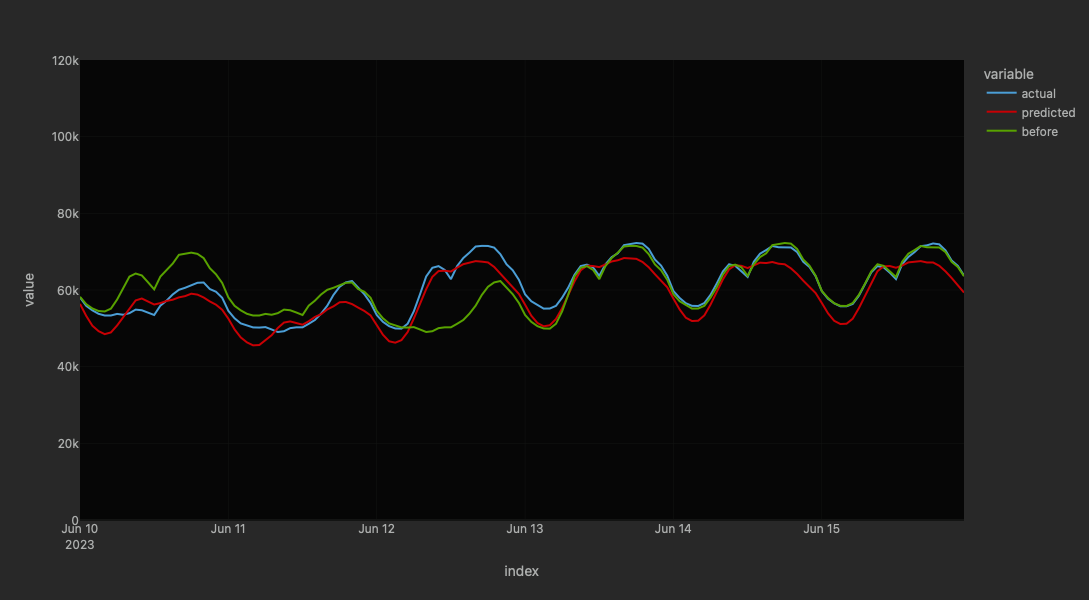

In [45]:
import plotly.express as px
from dash_bootstrap_templates import load_figure_template
load_figure_template(["minty",  "minty_dark", 'cyborg', 'cyborg_dark'])

start_date = '2023-06-10'
end_date = '2023-06-15'

data = actual_predicted_df.loc[start_date:end_date]
fig = px.line( data[['actual', 'predicted', 'before']], markers=False, template='cyborg', height=600)
fig.update_layout(yaxis_range=[0, 120000])
fig.show()